# Scanning hyperspace: how to tune machine learning models

## Introduction

When doing machine learning using Python's [`scikit-learn` library](http://scikit-learn.org/ ), you can often get reasonable predictive performance by using out-of-the-box settings for your models. However, the payoff can be huge if you invest at least some time into tuning models to your specific problem and dataset. [In the previous post](http://blog.cambridgecoding.com/2016/03/24/misleading-modelling-overfitting-cross-validation-and-the-bias-variance-trade-off/), we explored the concepts of overfitting, cross-validation, and the bias-variance tradeoff. These ideas turn out to be central to doing a good job at optimizing the **hyperparameters** (roughly, the settings) of algorithms. In this  post, we will explore the concepts behind hyperparameter optimization and demonstrate the process of tuning and training a random forest classifier.

You'll be working with the famous (well, machine learning famous!) [wine dataset](https://archive.ics.uci.edu/ml/datasets/Wine), which contains features of different quality wines, like the acidity and sugar content, as well as a quality rating. Our goal is to tune and apply a random forest to these features in order to predict whether a given wine is nice or not. 

The steps we'll cover in this blog post can be summarized as follows:

![Tutorial overview.](https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/polished_prediction/hyperparam_intro_rf_only-01.png)

Let's get cracking.

## Loading and exploring the dataset

We start off by collecting the dataset. It can be found both [online](http://www3.dsi.uminho.pt/pcortez/wine/) and in our GitHub repository, so we can also just fetch it with `wget` (note: make sure you first type `pip install wget` into your terminal since `wget` is not a preinstalled Python library). This command will download a copy of the dataset to your current working directory.

In [1]:
import wget
import pandas as pd

# Import the dataset
data_url = 'https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/datasets/wine/winequality-red.csv'
dataset = wget.download(data_url)
dataset = pd.read_csv(dataset, sep=";")

If you're interested in getting to know the wine dataset graphically, check out a previous post on using the plotly library to make interactive plots of the wine features [here](http://blog.cambridgecoding.com/2016/02/07/eda-and-interactive-figures-with-plotly/). 

Let's have a brief look here:

In [2]:
# Take a peak at the first few columns of the data
first_5_columns = dataset.columns[0:5]
dataset[first_5_columns].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides
0,7.4,0.70,0.00,1.9,0.076
1,7.8,0.88,0.00,2.6,0.098
2,7.8,0.76,0.04,2.3,0.092
3,11.2,0.28,0.56,1.9,0.075
4,7.4,0.70,0.00,1.9,0.076


You can examine the dimensions of the dataset and the column names:

In [3]:
# Examine shape of dataset and the column names
print (dataset.shape)
print (dataset.columns.values)

(1599, 12)
['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality']


So, it looks like you have a dozen features to play with, and just under 1600 data points. Get some summary statistics on the features using `describe()`:

In [4]:
# Summarise feature values
dataset.describe()[first_5_columns]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467
std,1.741096,0.179060,0.194801,1.409928,0.047065
min,4.600000,0.120000,0.000000,0.900000,0.012000
25%,7.100000,0.390000,0.090000,1.900000,0.070000
50%,7.900000,0.520000,0.260000,2.200000,0.079000
75%,9.200000,0.640000,0.420000,2.600000,0.090000
max,15.900000,1.580000,1.000000,15.500000,0.611000


The distribution of the outcome variable `quality` is a bit funky - the values are mostly 5 and 6 (how would you check this?). This could get a bit irksome later on, so go ahead and recode the quality scores into something more convenient. One idea would be to label wines as being either high quality (e.g. if their score is 6 or higher) or low quality (if the score is 6 or lower). You could encode this with a `1` representing high quality and `0` representing low quality, like so:

In [5]:
# using a lambda function to bin quality scores
dataset['quality_is_high'] = dataset.quality.apply(lambda x: 1 if x >= 6 else 0)

Now convert the pandas dataframe into a numpy array and isolate the outcome variable you'd like to predict ('quality_is_high'). This conversion is needed to feed the data into the machine learning pipeline:

In [6]:
import numpy as np

# Convert the dataframe to a numpy array and split the
# data into an input matrix X and class label vector y
npArray = np.array(dataset)
X = npArray[:,:-2].astype(float)
y = npArray[:,-1]

Now that you have the dataset set up, the machine learning can begin. First, you have to split the dataset into a training and test set (see [previous post](http://blog.cambridgecoding.com/2016/03/24/misleading-modelling-overfitting-cross-validation-and-the-bias-variance-trade-off/) for an explanation of why this is a good idea):

In [7]:
from sklearn.cross_validation import train_test_split

# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1)

## Setting up a Random Forest

You are now going to try to predict what is a high quality wine using a random forest classifier. Chapter 8 of the [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf) book provides a truly excellent introduction to the theory behind classification trees, bagged trees, and random forests. It's worth a read if you have time.

Briefly, random forests build a collection of [classification trees](http://www.cise.ufl.edu/~adobra/datamining/scribing/scribe_01_06_2005.pdf), where each tree tries to classify data points into classes by recursively splitting the data on the features (and feature values) that separate the classes best. Each tree is trained on [bootstrapped](https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29) data, and each bifurcation point is only allowed to 'see' a subset of the available variables when deciding on the best split. So, these two elements of randomness are introduced when constructing each tree, which means that a variety of different trees are built. The random forest then ensembles these base learners together, i.e. it combines these trees into an aggregated model. The end result of all of this is that when you want to classify a new data point, the individual trees each make their individual predictions, and the random forest surveys these opinions and accepts the majority position. This approach often leads to improved accuracy, generalizability, and stability in the predictions.

## Predicting wine quality with a random forest

Out of the box, scikit's random forest classifier performs reasonably well on the wine dataset:

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf = RandomForestClassifier()
rf.fit(XTrain, yTrain)

rf_predictions = rf.predict(XTest)

print (metrics.classification_report(yTest, rf_predictions))
print ("Overall Accuracy:", round(metrics.accuracy_score(yTest, rf_predictions),4))

             precision    recall  f1-score   support

        0.0       0.74      0.81      0.77       188
        1.0       0.82      0.75      0.78       212

avg / total       0.78      0.78      0.78       400

('Overall Accuracy:', 0.7775)


The model has an overall accuracy around the 0.79 mark (there is some variability in this value - try rerunning the code block several times, or setting different seeds using `random_state`). This means that 79% of the time, your model is able to predict the right class when given the test data. In other words, it can distinguish pretty well between a good and a bad wine based on their chemical properties.

Next up, you are going to learn how to pick the best values for the hyperparameters of the random forest algorithm in order to get better models with (hopefully!) even higher accuracy than this baseline.

## Better modelling through hyperparameter optimization

We've glossed over what a hyperparameter actually is. Let's explore the topic now. Often, when setting out to train a machine learning algorithm on your dataset of interest, you must first specify a number of arguments or **hyperparameters** (HPs). An HP is just a variable than influences the performance of your model, but isn't directly tuned during model training.

For example, when using the random forest algorithm to do classification, you have to set the value of the hyperparameter `n_estimators` ahead of time, before training commences. `n_estimators` controls the number of individual trees in the random forest ensemble. The more the better (with diminishing returns), but more trees come at the expense of longer training time.

As mentioned above, `scikit-learn` generally provides reasonable hyperparameter default values, such that it is possible to quickly build an e.g. a random forest classifier by simply typing `RandomForestClassifier()` and then fitting it to your data. We can can get the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) on what hyperparameter values that the classifier has automatically assumed, but you can also examine models directly using `get_params`:

In [9]:
# Create a default random forest classifer and print its parameters
rf_default = RandomForestClassifier()
print(rf_default.get_params)

<bound method RandomForestClassifier.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>


You can see that `n_estimators` takes on a default value of 10. Other hyperparameters include `max_features`, which controls the size of the random selection of features the algorithm is allowed to consider when splitting a node. The default is `max_features='auto'`, where the `auto` refers to `sqrt` of the number of all features in classification problems. So for instance, if we have 16 features in total, then trees are restricted to considering only 4 features at each bifurcation point (instead of searching *all* features for the best split). Other important HPs include the `max_depth`, which restricts the depth of the trees you grow, and `criterion`, which dictates how trees calculate the class purity resulting from splits.

As we saw above, the default settings for random forests do a good job. But it's a good idea to try to improve your learning algorithm's performance. But how do you know what values to set the hyperparameters to in order to get the best performance from your learning algorithms? 

You optimize hyperparameters in exactly the way that you might expect - you try different values and see what works best. However, some care is needed when deciding how exactly to  measure if certain values work well, and which strategy to use to systematically explore **hyperparameter space**. 

## Tuning your random forest

In order to build the best possible model that does a good job at describing the underlying trends in a dataset, we need to pick the right HP values. The most basic strategy to do this would be just to test different possible values for the HPs and see how the model performs. 

Let's try out some random HP values:

In [10]:
# manually specifying some HP values
hp_combinations = [
    {"n_estimators": 2, "max_features": None},  # all features are considered
    {"n_estimators": 5, "max_features": 'log2'},
    {"n_estimators": 9, "max_features": 'sqrt'} 
]

We can manually write a small loop to test out how well the different combinations of these potential HP values fare (later, you'll see better ways to do this): 

In [11]:
# test out different HP combinations
for hp_combn in hp_combinations:
        
    # Train and output accuracies
    rf = RandomForestClassifier(
        n_estimators=hp_combn["n_estimators"], 
        max_features=hp_combn["max_features"]
    )
    
    rf.fit(XTrain, yTrain)
    rf_predictions = rf.predict(XTest)
    print ('When n_estimators is {} and max_features is {}, test set accuracy is {}'.format(
            hp_combn["n_estimators"],
            hp_combn["max_features"], 
            round(metrics.accuracy_score(yTest, rf_predictions),2))
          )
           

When n_estimators is 2 and max_features is None, test set accuracy is 0.71
When n_estimators is 5 and max_features is log2, test set accuracy is 0.78
When n_estimators is 9 and max_features is sqrt, test set accuracy is 0.78


Looks like the last combinations of HPs might be doing better. However, manually searching for the best HPs in this way is not efficient, it's a bit random, and liable to miss good combinations. There is however a solution, i.e. **grid search**.

## Grid search

Traditionally and perhaps most intuitively, scanning for good HPs values can be done with **grid search** (also called parameter sweep). This strategy exhaustively searches through some manually prespecified HP values and reports the best option. It is common to try to optimize multiple HPs simultaneously - grid search tries each combination of HPs in turn and reports the best one, hence the name 'grid'. This is a more convenient and complete way of searching through hyperparameter space than manually specifying combinations.

For instance, you could build a grid like this:

![Grid search example](https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/polished_prediction/grid_search.png)

Using these commands (see also itertools.product for getting all combinations of variables):

In [12]:
import itertools

n_estimators = [2, 5, 9]
max_features = [None, 'log2', 'sqrt']

hp_combinations = list(itertools.product(n_estimators, max_features))
print (hp_combinations)
print ("The number of HP combinations is: {}".format(len(hp_combinations)))

[(2, None), (2, 'log2'), (2, 'sqrt'), (5, None), (5, 'log2'), (5, 'sqrt'), (9, None), (9, 'log2'), (9, 'sqrt')]
The number of HP combinations is: 9


However there is a **massive pitfall** here! Scanning through all possible combinations of HPs to build models and evaluating them on the test set will inadvertently come up with one combination of parameters that does best, but this result might not generalise well. This approach is less misguided than  trying to optimize models by evaluating them on the *training set*, is still not ideal. The problem is that during repeated evaluation on the test dataset, knowledge of the test set can leak into the model bulding phase. You are at risk of inadvertenly learning something about the test set, and hence are susceptible to [**overfitting**](http://blog.cambridgecoding.com/2016/03/24/misleading-modelling-overfitting-cross-validation-and-the-bias-variance-trade-off/). How does one get around these issues?

## Grid search with k-fold cross validation for hyperparameter tuning

Enter **k-fold cross-validation**, which is a handy technique for measuring a model's performance using *only* the training set. k-fold CV is a general method (see an explanation [here](http://blog.cambridgecoding.com/2016/03/24/misleading-modelling-overfitting-cross-validation-and-the-bias-variance-trade-off/)), and is not specific to hyperparameter optimization, but is very useful for that purpose. We simply try out different HP values, get several different estimates of model performance for each HP value (or combination of HP values), and choose the model with the lowest CV error. With 10-fold CV, the process looks like this:

![Diagram showing the steps behind 10-fold cross-validation for hyperparameter optimization.](./gridsearch_cv.png)

In the context of HP optimization, we perform k-fold cross validation **together with grid search** to get a more robust estimate of the model performance associated with specific HP values. The combination of grid search and k-fold cross validation is very popular for finding the models with good performance and generalisability. So, in HP optimisation we are actually trying to do two things:

* Find the combination of HPs that improves model performance (e.g. accuracy) 
* Make sure that this choice of HPs will generalize well to new data

The CV is there to address the second concern. `scikit-learn` makes grid search with k-fold CV very easy and slick to do, and even supports parallel distributing of the search (via the `n_jobs` argument). The set-up looks like this:

In [13]:
from sklearn.grid_search import GridSearchCV

# Search for good hyperparameter values
# Specify values to grid search over
n_estimators = list(np.arange(10, 60, 20))
max_features = [None, 'sqrt', 'log2']  # we need to change the all to somthing better!

hyperparameters = {
    'n_estimators': n_estimators, 
    'max_features': max_features
}

# Grid search using cross-validation
gridCV = GridSearchCV(RandomForestClassifier(), param_grid=hyperparameters, cv=10, n_jobs=4)

Next, you tell the model to use the training data to perform the grid search with 10 fold CV. You can then collect the best combination of HP values with the model attribute `best_params_`:

In [14]:
# Perform grid search with 10-fold CV
gridCV.fit(XTrain, yTrain)

# Identify optimal hyperparameter values
best_n_estim      = gridCV.best_params_['n_estimators']
best_max_features = gridCV.best_params_['max_features']  

print("The best performing n_estimators value is: {}".format(best_n_estim))
print("The best performing max_features value is: {}".format(best_max_features))

The best performing n_estimators value is: 30
The best performing max_features value is: sqrt


You can visually represent the results from this grid search (which can be found in `gridCV.grid_scores_`) with a heatmap:

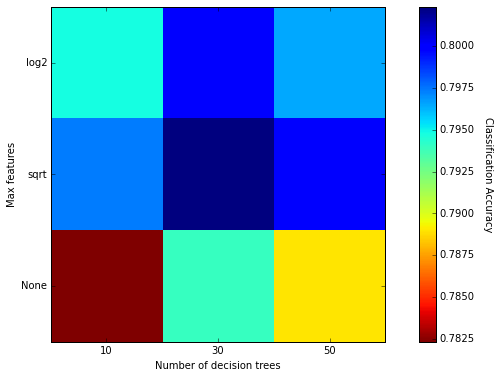

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# fetch scores, reshape into a grid
scores = [x[1] for x in gridCV.grid_scores_]
scores = np.array(scores).reshape(len(n_estimators), len(max_features))
scores = np.transpose(scores)

# Make heatmap from grid search results
plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap='jet_r')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_features)), max_features)
plt.xlabel('Number of decision trees')
plt.ylabel('Max features')
plt.colorbar().set_label('Classification Accuracy', rotation=270, labelpad=20)
plt.show()

Finally, you can now train a new random forest on the wine dataset using what you have learned from the grid search:

In [44]:
# Train classifier using optimal hyperparameter values
# We could have also gotten this model out from gridCV.best_estimator_
rf = RandomForestClassifier(n_estimators=best_n_estim,
                            max_features=best_max_features)

rf.fit(XTrain, yTrain)
rf_predictions = rf.predict(XTest)

print (metrics.classification_report(yTest, rf_predictions))
print ("Overall Accuracy:", round(metrics.accuracy_score(yTest, rf_predictions),2))

             precision    recall  f1-score   support

        0.0       0.79      0.84      0.81       188
        1.0       0.84      0.80      0.82       212

avg / total       0.82      0.81      0.82       400

('Overall Accuracy:', 0.81)


Congratulations, you tuned and applied your random forest classifier! We now get ~0.81 accuracy. This is quite a bit better than the poorly parameterized models which yielded ~0.7 accuracy, and is a noticeable difference from the default 0.77-0.79 values. Importantly, it was not too difficult to get this boost - scikit can do grid search with k-fold CV in 1 line of code. How could you try to improve performance further?

Note that grid search with k-fold CV simply returns the best HP values out of the available options, and is therefore not guaranteed to return a global optimum. It makes sense to choose a diverse collection of possible values that is somewhat centred around an empirically sensible default.

## Conclusion

So, that was an overview of the concepts and practicalities involved when tuning a random forest classifer. You started with the motivation for tuning machine learning algorithms (i.e. nicer, bigger numbers in your models' performance reports!). You then evaluated different candidate models by simple trial and error, as well as by using grid search with k-fold cross validation. You then ran the best possible model on the test set in order to predict wine quality from a set of chemical characteristics, and made correct predictions 81% of the time. We could have chosen to tune [various other hyperpramaters](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), but the two we focused on are regarded as quite important.  

In our next post, we will explore different ways to tune models and how to optimise a support vector machine and logistic regression classifier. Stay... tuned! *Cue groans*.

### Quick quiz:

Now that you're familiar with adjusting and optimizing the behaviour of random forests in classification tasks, see if you can tackle these questions (feel free to leave your answers in the comments section):

1. How do you think that altering the `n_estimators` and `max_depth` HPs would affect the bias and variance of a random forest classifier?

2. To get more of an intuition of how random forests operate, play around with printing the importance of the features with `print (rf.feature_importances_)` under different conditions. What happens to the features importances when you set `max_depth=0`?

3. Try setting `max_features=1`. What does this force the trees in the random forest to do? `

4. Bonus question: It is interesting that the random forest performs better on the wine data with quite low values of `max_features`. What do you think this says about the features in the dataset?